TODO:
- [ ] Change data pattern

- ACT uses ReLU also works
- Increasing TRAIN_SIZE will result in more clear boundary, TRAIN_SIZE = 1000 no guarantee 100% acc

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from boring_utils.utils import *

%matplotlib inline 
init_graph()
device = get_device()
set_seed(42)

Parameters

In [2]:
LOSS = 'BCELogits'
# LOSS = 'CE'

# ACT = nn.ReLU()
ACT = nn.Tanh()

# TRAIN_SIZE = 1000
TRAIN_SIZE = 2500

# NN, Optm and Loss

In [4]:
class SimpleClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        
        self.ln1 = nn.Linear(in_dim, hidden_dim)
        self.ln2 = nn.Linear(hidden_dim, out_dim)

        self.ac = ACT

    def forward(self, x):
        x = self.ln1(x)
        x = self.ac(x)
        x = self.ln2(x)

        return x


# XOR
if LOSS == 'BCELogits':
    model = SimpleClassifier(2, 4, 1)
    criterion = nn.BCEWithLogitsLoss()
else:
    model = SimpleClassifier(2, 4, 2)
    criterion = nn.CrossEntropyLoss()

# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

cprint(model)

<module> -> model:
SimpleClassifier(
  (ln1): Linear(in_features=2, out_features=4, bias=True)
  (ln2): Linear(in_features=4, out_features=1, bias=True)
  (ac): ReLU()
)


In [5]:
for name, param in model.named_parameters():
    print("Parameter %s, shape %s" % (name, str(param.shape)))

Parameter ln1.weight, shape torch.Size([4, 2])
Parameter ln1.bias, shape torch.Size([4])
Parameter ln2.weight, shape torch.Size([1, 4])
Parameter ln2.bias, shape torch.Size([1])


# Data

In [6]:
temp_data = torch.randint(0, 2, (10, 2)).float()
temp_label = (temp_data.sum(dim=1) == 1).float().view(-1, 1)
cprint(temp_data.shape, temp_data.sum(dim=1))
# cprint(temp_label)

<module> -> temp_data.shape:
torch.Size([10, 2])
<module> -> temp_data.sum(dim=1):
tensor([2., 1., 1., 2., 2., 2., 1., 1., 2., 1.])


In [7]:
class XORDataset(Dataset):
    def __init__(self, size, std = 0.1):
        self.size = size
        self.std = std
        self.generate_continuous_xor()
    
    def generate_continuous_xor(self):
        '''
        Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        The label is their XOR combination
        '''

        # self.size, 2 => size of (x, y)
        data = torch.randint(0, 2, (self.size, 2)).float()
        self.label = (data.sum(dim=1) == 1).float()

        # add noise
        self.data = data + self.std * torch.randn(data.shape)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


# Create a demo dataset for visualization
dataset = XORDataset(size=200)
cprint(len(dataset))
cprint(dataset[0])

<module> -> len(dataset):
200
<module> -> dataset[0]:
(tensor([-0.0048,  0.0669]), tensor(0.))


In [8]:
mprint(dataset, magic_methods=False, private_methods=False)


Public Methods:
    data
    generate_continuous_xor
    label
    size
    std


In [9]:
cprint(dataset.data.shape, dataset.label.shape)

<module> -> dataset.data.shape:
torch.Size([200, 2])
<module> -> dataset.label.shape:
torch.Size([200])


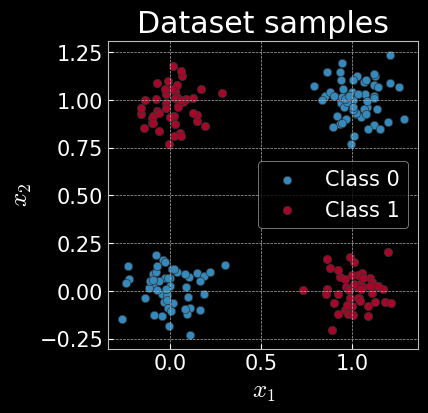

In [10]:
def vis_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy().flatten()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()


vis_samples(dataset.data, dataset.label)
plt.show()

# Dataloader

In [11]:
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [12]:
data_inputs, data_labels = next(iter(data_loader))

cprint(data_inputs, data_labels)

<module> -> data_inputs:
tensor([[ 0.1248,  1.0093],
        [ 1.1444,  0.0232],
        [ 1.2093,  1.0876],
        [ 0.9821,  1.0200],
        [ 1.0882, -0.1324],
        [ 0.1830,  0.0778],
        [ 1.0036,  1.1037],
        [ 1.0367, -0.0391]])
<module> -> data_labels:
tensor([1., 1., 0., 0., 1., 0., 0., 1.])


# Training

In [13]:
train_dataset = XORDataset(size=TRAIN_SIZE)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model.to(device)

SimpleClassifier(
  (ln1): Linear(in_features=2, out_features=4, bias=True)
  (ln2): Linear(in_features=4, out_features=1, bias=True)
  (ac): ReLU()
)

In [14]:
def train(model, data_loader, optimizer, criterion, epochs=100):
    model.train()
    for epoch in tqdm(range(epochs)):
        for data, label in data_loader:
            # Move input data to device
            if LOSS == 'CE':
                data, label = data.to(device), label.to(device).long()
            else:
                data, label = data.to(device), label.to(device)

            preds = model(data)
            # Output is [Batch size, 1], but we want [Batch size]
            preds = preds.squeeze(dim=1)
            loss = criterion(preds, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


train(model, train_data_loader, optimizer, criterion)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
model.state_dict()

OrderedDict([('ln1.weight',
              tensor([[-0.8605,  1.3706],
                      [-3.7187,  3.6818],
                      [-2.1206,  1.9479],
                      [-0.9142,  0.9067]], device='cuda:0')),
             ('ln1.bias',
              tensor([ 0.7498, -0.1979,  1.9174, -0.0500], device='cuda:0')),
             ('ln2.weight',
              tensor([[-1.5188,  5.1671, -3.4053,  1.1650]], device='cuda:0')),
             ('ln2.bias', tensor([2.8306], device='cuda:0'))])

# Eval

In [16]:
test_dataset = XORDataset(size=500)

# NOTE: in test, don't drop last!!!
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False) 

In [17]:
def eval_model(model, data_loader):
    model.eval()
    true_preds, num_preds = 0., 0.

    with torch.no_grad():
        for data, label in data_loader:
            data, label = data.to(device), label.to(device)
            preds = model(data)
            # torch.Size([128, 1])
            # cprint(output.shape, label.shape)
            preds = preds.squeeze(dim=1)

            if LOSS == 'CE':
                preds = preds.argmax(dim=1)  # for CE
            else:
                preds = torch.sigmoid(preds)  # for BCEWithLogits

            preds = (preds > 0.5).float()

            true_preds += (preds == label).sum()
            num_preds += label.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")


eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


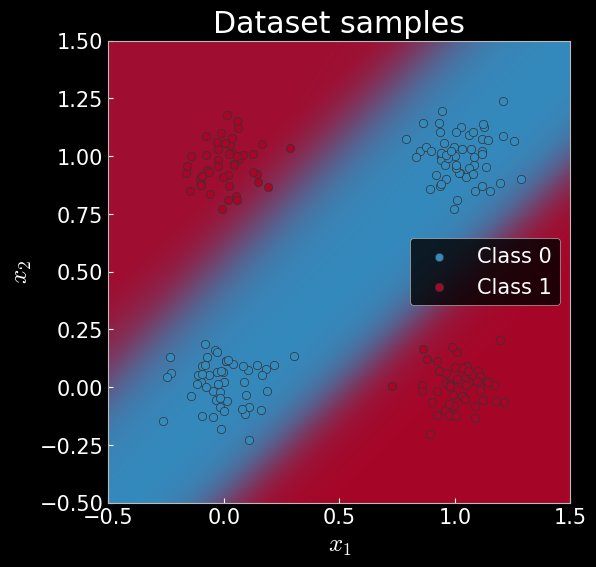

In [18]:
@torch.no_grad()  # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy().flatten()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy

    model_inputs = torch.stack([xx1, xx2], dim=-1)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    preds = model(model_inputs)

    # for CE
    if LOSS == 'CE':
        preds_proba = torch.softmax(preds, dim=-1)
        # output_image = torch.zeros((*preds_proba.shape[:2], 3), device=preds_proba.device)
        # output_image[:,:,0] = preds_proba[:,:,0] 
        # output_image[:,:,1] = preds_proba[:,:,1]
        output_image = preds_proba[:,:,0,None] * c0 + preds_proba[:,:,1,None] * c1

    # for BCEWithLogits
    else:
        preds = torch.sigmoid(preds)
        output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one

    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()